# Solving the Traveling Salesman Problem with Genetic Algorithms

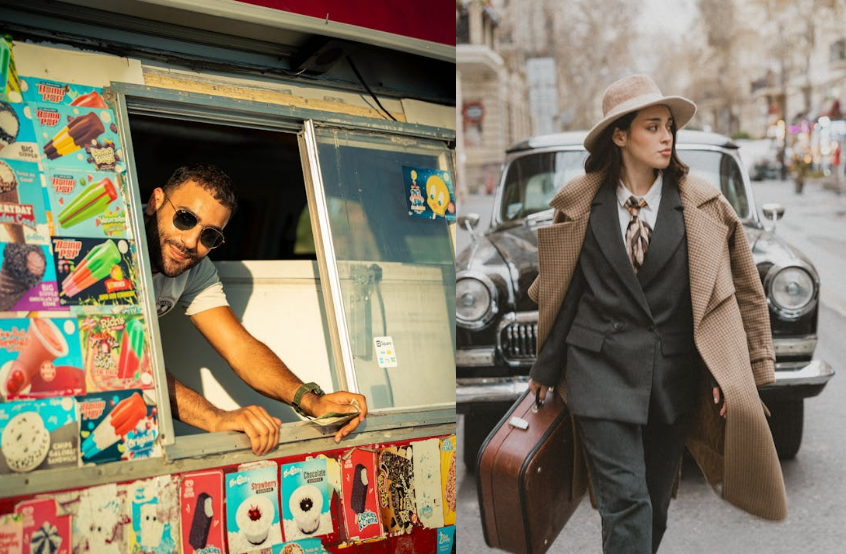

## Introduction

The Traveling Salesman Problem (TSP) is one of the most famous problems in computer science and operations research. It asks the following question: 

**"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?"**

Despite its simple description, the TSP is an NP-hard problem, which means there's no known algorithm that can efficiently find the optimal solution for large instances. This makes it an excellent candidate for approximation algorithms like genetic algorithms, which can find good (though not necessarily optimal) solutions in a reasonable amount of time.

In this notebook, we'll implement a genetic algorithm to solve the TSP, exploring different genetic operators and optimization techniques along the way. While genetic algorithms may not always find the optimal solution to TSP, they are valuable for finding good approximations in reasonable time, especially for larger instances where exact methods become impractical. For further exploration, consider other metaheuristics like Ant Colony Optimization, Particle Swarm Optimization, or hybrid approaches that combine the strengths of multiple algorithms.

## 1. Problem Setup and Visualization

First, let's set up the problem by defining cities and visualizing them.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd

from tsp import TSP

# Random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [ ]:
# Create TSP instances with different city distributions
random_tsp = TSP(num_cities=25, mode='random')
circle_tsp = TSP(num_cities=25, mode='circle')
grid_tsp = TSP(num_cities=25, mode='grid')
clustered_tsp = TSP(num_cities=25, mode='clustered')

# Display the city distributions
random_tsp.plot_cities("Random City Distribution")
circle_tsp.plot_cities("Circular City Distribution")
grid_tsp.plot_cities("Grid City Distribution")
clustered_tsp.plot_cities("Clustered City Distribution")

In [ ]:
# We'll use the random distribution for our main experiments
tsp = random_tsp

## 2. Initial Solutions

Before diving into genetic algorithms, let's explore some simple ways to generate initial solutions.

In [ ]:
def random_route(tsp):
    """Generate a random route visiting all cities once"""
    route = list(range(tsp.num_cities))
    random.shuffle(route)
    return route

In [ ]:
def nearest_neighbor(tsp, start_city=0):
    """
    Generate a route using the nearest neighbor heuristic
    
    Args:
        tsp: TSP instance
        start_city: Starting city index
        
    Returns:
        Route generated by always visiting the closest unvisited city
    """
    route = [start_city]
    unvisited = set(range(tsp.num_cities))
    unvisited.remove(start_city)
    
    while unvisited:
        current = route[-1]
        # Find closest unvisited city
        next_city = min(unvisited, key=lambda city: tsp.distances[current, city])
        route.append(next_city)
        unvisited.remove(next_city)
        
    return route

In [ ]:
def greedy_route(tsp):
    """
    Try all possible starting cities with nearest neighbor and return the best route
    
    Args:
        tsp: TSP instance
        
    Returns:
        The best route found by nearest neighbor starting from any city
    """
    best_route = None
    best_distance = float('inf')
    
    for start in range(tsp.num_cities):
        route = nearest_neighbor(tsp, start)
        distance = tsp.route_distance(route)
        
        if distance < best_distance:
            best_distance = distance
            best_route = route
            
    return best_route


Let's try these initial solution methods:

In [ ]:
# Generate and evaluate different initial routes
random_solution = random_route(tsp)
nn_solution = nearest_neighbor(tsp)
greedy_solution = greedy_route(tsp)

print(f"Random Solution Distance: {tsp.route_distance(random_solution):.2f}")
print(f"Nearest Neighbor Solution Distance: {tsp.route_distance(nn_solution):.2f}")
print(f"Greedy Solution Distance: {tsp.route_distance(greedy_solution):.2f}")

In [ ]:
tsp.plot_route(random_solution, "Random Solution")
tsp.plot_route(nn_solution, "Nearest Neighbor Solution")
tsp.plot_route(greedy_solution, "Greedy Solution")

## 3. Genetic Algorithm Components

Now let's implement the key components of our genetic algorithm for TSP:

### 3.1 Fitness Function

In TSP, fitness is inversely related to the total route distance (shorter distances are better).

In [ ]:
def calculate_fitness(tsp, route):
    """
    Calculate fitness of a route (inverse of distance)
    
    Args:
        tsp: TSP instance
        route: A route represented as a list of city indices
    
    Returns:
        Fitness value (higher is better)
    """
    distance = tsp.route_distance(route)
    # Use inverse of distance so higher fitness is better
    return 1 / distance

### 3.2 Selection Operators

Let's implement a few selection methods for choosing parents for crossover:

In [ ]:
def tournament_selection(tsp, population, tournament_size=3):
    """
    Select a route using tournament selection
    
    Args:
        tsp: TSP instance
        population: List of routes
        tournament_size: Number of routes to compete in each tournament
    
    Returns:
        Selected route
    """
    # Randomly select tournament_size routes from the population
    tournament = random.sample(population, min(tournament_size, len(population)))
    
    # Find the best route in the tournament
    best_route = max(tournament, key=lambda route: calculate_fitness(tsp, route))
    
    return best_route

In [ ]:
def roulette_wheel_selection(tsp, population):
    """
    Select a route using roulette wheel (fitness proportionate) selection
    
    Args:
        tsp: TSP instance
        population: List of routes
    
    Returns:
        Selected route
    """
    # Calculate fitness for each route
    fitnesses = [calculate_fitness(tsp, route) for route in population]
    
    total_fitness = sum(fitnesses)
    
    # Handle case where all fitnesses are 0
    if total_fitness == 0:
        return random.choice(population)
    
    # Generate a random value
    selection_point = random.uniform(0, total_fitness)
    
    # Find the selected route
    current_fitness = 0
    for route, fitness in zip(population, fitnesses):
        current_fitness += fitness
        if current_fitness >= selection_point:
            return route
    
    # Fall back to last route if rounding issues
    return population[-1]

In [ ]:
def rank_selection(tsp, population):
    """
    Select a route using rank-based selection
    
    Args:
        tsp: TSP instance
        population: List of routes
    
    Returns:
        Selected route
    """
    # Sort population by fitness (ascending)
    sorted_population = sorted(
        population,
        key=lambda route: calculate_fitness(tsp, route)
    )
    
    # Assign ranks (higher ranks for better fitness)
    ranks = list(range(1, len(sorted_population) + 1))
    
    rank_sum = sum(ranks)
    
    # Select based on rank
    selection_point = random.uniform(0, rank_sum)
    
    current_sum = 0
    for route, rank in zip(sorted_population, ranks):
        current_sum += rank
        if current_sum >= selection_point:
            return route
    
    # Fall back to last route if rounding issues
    return sorted_population[-1]

### 3.3 Crossover Operators

For TSP, we need special crossover operators that maintain the constraint that each city appears exactly once in the route.

In [ ]:
def ordered_crossover(parent1, parent2):
    """
    Perform ordered crossover (OX) between two parent routes
    
    Args:
        parent1, parent2: Parent routes
    
    Returns:
        Two child routes
    """
    size = len(parent1)
    
    # Generate random segment indices
    point1, point2 = sorted(random.sample(range(size), 2))
    
    # Create children
    def create_child(p1, p2):
        # Copy segment from first parent
        child = [None] * size
        for i in range(point1, point2 + 1):
            child[i] = p1[i]
        
        # Fill remaining positions with cities from second parent (in order)
        remaining = [item for item in p2 if item not in child]
        
        # Fill gaps before and after segment
        index = 0
        for i in range(size):
            if child[i] is None:
                child[i] = remaining[index]
                index += 1
                
        return child
    
    # Create two children with parents swapped
    child1 = create_child(parent1, parent2)
    child2 = create_child(parent2, parent1)
    
    return child1, child2

In [ ]:
def cycle_crossover(parent1, parent2):
    """
    Perform cycle crossover (CX) between two parent routes
    
    Args:
        parent1, parent2: Parent routes
    
    Returns:
        Two child routes
    """
    size = len(parent1)
    
    # Initialize children
    child1 = [None] * size
    child2 = [None] * size
    
    # Create mapping from value to position
    p1_positions = {city: i for i, city in enumerate(parent1)}
    
    # Keep track of assigned positions
    assigned = [False] * size
    
    # Alternate which parent values come from
    parent1_turn = True
    
    # Continue until all positions are assigned
    for start_pos in range(size):
        # Skip if already assigned
        if assigned[start_pos]:
            continue
        
        # Start a new cycle
        pos = start_pos
        while not assigned[pos]:
            # Assign value from the appropriate parent
            if parent1_turn:
                child1[pos] = parent1[pos]
                child2[pos] = parent2[pos]
            else:
                child1[pos] = parent2[pos]
                child2[pos] = parent1[pos]
            
            assigned[pos] = True
            
            # Move to the position of the next element in the cycle
            value = parent2[pos]
            pos = p1_positions[value]
        
        # Switch parent for next cycle
        parent1_turn = not parent1_turn
    
    return child1, child2

### 3.4 Mutation Operators

Mutation operators for TSP need to maintain the constraint that each city appears exactly once.

In [ ]:
def swap_mutation(route, mutation_rate=0.01):
    """
    Perform swap mutation on a route
    
    Args:
        route: The route to mutate
        mutation_rate: Probability of each position being mutated
    
    Returns:
        Mutated route
    """
    # Clone the route
    mutated = route.copy()
    size = len(route)
    
    # Determine how many swaps to perform
    num_swaps = max(1, int(mutation_rate * size))
    
    for _ in range(num_swaps):
        # Choose two random positions
        i, j = random.sample(range(size), 2)
        
        # Swap the cities
        mutated[i], mutated[j] = mutated[j], mutated[i]
        
    return mutated

In [ ]:
def inversion_mutation(route, mutation_rate=0.1):
    """
    Perform inversion mutation on a route
    
    Args:
        route: The route to mutate
        mutation_rate: Probability of mutation occurring
    
    Returns:
        Mutated route
    """
    if random.random() > mutation_rate:
        return route.copy()
    
    # Clone the route
    mutated = route.copy()
    size = len(route)
    
    # Choose two random positions
    i, j = sorted(random.sample(range(size), 2))
    
    # Reverse the segment between i and j
    mutated[i:j+1] = reversed(mutated[i:j+1])
    
    return mutated

In [ ]:
def scramble_mutation(route, mutation_rate=0.1):
    """
    Perform scramble mutation on a route
    
    Args:
        route: The route to mutate
        mutation_rate: Probability of mutation occurring
    
    Returns:
        Mutated route
    """
    if random.random() > mutation_rate:
        return route.copy()
    
    # Clone the route
    mutated = route.copy()
    size = len(route)
    
    # Choose two random positions
    i, j = sorted(random.sample(range(size), 2))
    
    # Scramble the segment between i and j
    segment = mutated[i:j+1]
    random.shuffle(segment)
    mutated[i:j+1] = segment
    
    return mutated

In [ ]:
def insertion_mutation(route, mutation_rate=0.1):
    """
    Perform insertion mutation on a route
    
    Args:
        route: The route to mutate
        mutation_rate: Probability of mutation occurring
    
    Returns:
        Mutated route
    """
    if random.random() > mutation_rate:
        return route.copy()
    
    # Clone the route
    mutated = route.copy()
    size = len(route)
    
    # Choose two random positions
    i, j = random.sample(range(size), 2)
    
    # Insert city from position i after position j
    city = mutated.pop(i)
    # Make sure that if j was after i, we adjust it
    if j > i:
        j -= 1
    mutated.insert(j + 1, city)
    
    return mutated


## 4. Complete Genetic Algorithm

Now let's put everything together into a complete genetic algorithm for solving the TSP:

In [ ]:
def genetic_algorithm_tsp(tsp, population_size=100, generations=500, 
                         elite_size=20, tournament_size=5,
                         mutation_rate=0.01, crossover_rate=0.8,
                         selection_method='tournament',
                         crossover_method='ordered',
                         mutation_method='inversion'):
    """
    Solve the TSP using a genetic algorithm
    
    Args:
        tsp: TSP instance
        population_size: Size of the population
        generations: Number of generations to run
        elite_size: Number of best routes to keep unchanged
        tournament_size: Size of tournament for selection
        mutation_rate: Probability of mutation
        crossover_rate: Probability of crossover
        selection_method: Method for parent selection
        crossover_method: Method for crossover
        mutation_method: Method for mutation
        
    Returns:
        Best route found, all best routes, distances
    """
    # Initialize population
    population = []
    
    # Start with one greedy solution
    population.append(greedy_route(tsp))
    
    # Fill the rest with random routes
    for _ in range(population_size - 1):
        population.append(random_route(tsp))
    
    # Selection function based on method
    if selection_method == 'tournament':
        select_parent = lambda: tournament_selection(tsp, population, tournament_size)
    elif selection_method == 'roulette':
        select_parent = lambda: roulette_wheel_selection(tsp, population)
    elif selection_method == 'rank':
        select_parent = lambda: rank_selection(tsp, population)
    else:
        raise ValueError(f"Unknown selection method: {selection_method}")
        
    # Crossover function based on method
    if crossover_method == 'ordered':
        crossover = ordered_crossover
    elif crossover_method == 'cycle':
        crossover = cycle_crossover
    else:
        raise ValueError(f"Unknown crossover method: {crossover_method}")
        
    # Mutation function based on method
    if mutation_method == 'swap':
        mutate = lambda route: swap_mutation(route, mutation_rate)
    elif mutation_method == 'inversion':
        mutate = lambda route: inversion_mutation(route, mutation_rate)
    elif mutation_method == 'scramble':
        mutate = lambda route: scramble_mutation(route, mutation_rate)
    elif mutation_method == 'insertion':
        mutate = lambda route: insertion_mutation(route, mutation_rate)
    else:
        raise ValueError(f"Unknown mutation method: {mutation_method}")
    
    # Track best route and history
    best_route = None
    best_distance = float('inf')
    best_routes_history = []
    best_distances_history = []
    
    # Run genetic algorithm for specified number of generations
    for generation in range(generations):
        # Evaluate current population
        population_with_fitness = [
            (route, calculate_fitness(tsp, route)) for route in population
        ]
        
        # Sort by fitness (descending)
        population_with_fitness.sort(key=lambda x: x[1], reverse=True)
        
        # Extract sorted routes
        sorted_routes = [route for route, _ in population_with_fitness]
        
        # Update best route
        current_best_route = sorted_routes[0]
        current_best_distance = tsp.route_distance(current_best_route)
        
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_route = current_best_route.copy()
        
        # Store history
        best_routes_history.append(best_route.copy())
        best_distances_history.append(best_distance)
            
        # Create next generation
        next_generation = []
        
        # Elitism: copy best routes directly to next generation
        next_generation.extend(sorted_routes[:elite_size])
        
        # Fill the rest of the population with offspring
        while len(next_generation) < population_size:
            # Select parents
            parent1 = select_parent()
            parent2 = select_parent()
            
            # Crossover with probability
            if random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            
            # Mutate children
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            # Add children to next generation
            next_generation.append(child1)
            if len(next_generation) < population_size:
                next_generation.append(child2)
        
        # Update population
        population = next_generation
    
    return best_route, best_routes_history, best_distances_history

In [ ]:
best_route, route_history, distance_history = genetic_algorithm_tsp(
    tsp,
    population_size=100,
    generations=300,
    elite_size=15,
    tournament_size=5,
    mutation_rate=0.01,
    crossover_rate=0.85,
    selection_method='tournament',
    crossover_method='ordered',
    mutation_method='inversion'
)

Let us plot the best route our algorithm found: 

In [ ]:
tsp.plot_route(best_route, "Genetic Algorithm Solution")

In [ ]:
# Plot the fitness history
plt.figure(figsize=(12, 6))
plt.plot(distance_history)
plt.title('Distance Improvement Over Generations')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

## 5. Comparing Different Operators

Let's compare different combinations of genetic operators to see which ones work best for TSP:

In [ ]:
def compare_operators(tsp, num_runs=5, generations=150):
    """
    Compare different combinations of genetic operators
    
    Args:
        tsp: TSP instance
        num_runs: Number of runs per combination
        generations: Number of generations per run
        
    Returns:
        DataFrame with results
    """
    # Define operator combinations to test
    selection_methods = ['tournament', 'roulette', 'rank']
    crossover_methods = ['ordered', 'cycle']
    mutation_methods = ['swap', 'inversion', 'scramble', 'insertion']
    
    # Store results
    results = []
    
    # Run experiments
    total_experiments = len(selection_methods) * len(crossover_methods) * len(mutation_methods)
    experiment_count = 0
    
    for selection in selection_methods:
        for crossover in crossover_methods:
            for mutation in mutation_methods:
                experiment_count += 1
                print(f"Running experiment {experiment_count}/{total_experiments}: "
                      f"{selection} selection, {crossover} crossover, {mutation} mutation")
                
                # Run multiple times to account for randomness
                distances = []
                for _ in range(num_runs):
                    _, _, distance_history = genetic_algorithm_tsp(
                        tsp,
                        population_size=80,
                        generations=generations,
                        elite_size=10,
                        selection_method=selection,
                        crossover_method=crossover,
                        mutation_method=mutation
                    )
                    
                    # Store final distance
                    distances.append(distance_history[-1])
                
                # Calculate statistics
                avg_distance = sum(distances) / len(distances)
                min_distance = min(distances)
                max_distance = max(distances)
                std_distance = (sum((d - avg_distance) ** 2 for d in distances) / len(distances)) ** 0.5
                
                # Store results
                results.append({
                    'Selection': selection,
                    'Crossover': crossover,
                    'Mutation': mutation,
                    'Avg Distance': avg_distance,
                    'Min Distance': min_distance,
                    'Max Distance': max_distance,
                    'Std Deviation': std_distance
                })
    
    # Convert to DataFrame and sort by average distance
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Avg Distance')
    
    return results_df

Note: This will take a while to run, so we'll use a smaller city set

In [ ]:
small_tsp = TSP(num_cities=15, mode='random')

In [ ]:
operator_results = compare_operators(small_tsp, num_runs=3, generations=100)
display(operator_results)

## 6. Scale-up Experiment

Finally, let's see how our algorithm scales with problem size:

In [ ]:
def scale_up_experiment(sizes=[10, 20, 30, 40, 50], runs=2):
    """
    Experiment with increasing problem sizes
    
    Args:
        sizes: List of problem sizes (number of cities)
        runs: Number of runs per size
        
    Returns:
        DataFrame with results
    """
    results = []
    
    for size in sizes:
        print(f"Testing with {size} cities...")
        
        # Create TSP instance
        test_tsp = TSP(num_cities=size, mode='random')
        
        # Track statistics
        distances = []
        times = []
        
        for run in range(runs):
            start_time = time.time()
            
            _, _, distance_history = genetic_algorithm_tsp(
                test_tsp,
                population_size=100,
                generations=200,
                elite_size=15
            )
            
            end_time = time.time()
            
            # Store results
            distances.append(distance_history[-1])
            times.append(end_time - start_time)
        
        # Calculate statistics
        avg_distance = sum(distances) / len(distances)
        min_distance = min(distances)
        avg_time = sum(times) / len(times)
        
        # Greedy solution for comparison
        greedy_sol = greedy_route(test_tsp)
        greedy_distance = test_tsp.route_distance(greedy_sol)
        
        # Random solution for comparison
        random_distances = [test_tsp.route_distance(random_route(test_tsp)) for _ in range(10)]
        avg_random_distance = sum(random_distances) / len(random_distances)
        
        # Calculate improvement percentages
        improvement_over_random = (avg_random_distance - avg_distance) / avg_random_distance * 100
        improvement_over_greedy = (greedy_distance - avg_distance) / greedy_distance * 100
        
        results.append({
            'Cities': size,
            'Avg GA Distance': avg_distance,
            'Min GA Distance': min_distance,
            'Greedy Distance': greedy_distance,
            'Avg Random Distance': avg_random_distance,
            'Improvement over Random (%)': improvement_over_random,
            'Improvement over Greedy (%)': improvement_over_greedy,
            'Avg Time (s)': avg_time
        })
    
    return pd.DataFrame(results)

In [ ]:
scale_results = scale_up_experiment(sizes=[10, 20, 30, 40, 50], runs=2)
display(scale_results)

## 7. Exercises

### Exercise 1: Island Model Implementation

Implement an island model where multiple sub-populations evolve independently and occasionally exchange individuals through migration. Compare its performance to the standard genetic algorithm.

```python
# Your code for island model implementation
def island_model_ga(tsp, num_islands=4, population_per_island=30, 
                   generations=300, migration_interval=20, 
                   migration_size=5):
    """
    Implement an island model genetic algorithm for TSP
    
    Args:
        tsp: TSP instance
        num_islands: Number of separate populations
        population_per_island: Population size per island
        generations: Number of generations
        migration_interval: How often to migrate between islands
        migration_size: Number of individuals to migrate
        
    Returns:
        Best route found
    """
    # Your implementation here
    pass
```

### Exercise 2: Self-Adapting Mutation Rate

Modify the algorithm to use self-adapting mutation rates where the mutation rate changes dynamically based on population diversity or improvement rate.

```python
# Your code for self-adapting mutation rate
def adaptive_mutation_rate(population, tsp, current_generation, 
                          improvement_history, base_rate=0.01):
    """
    Calculate adaptive mutation rate based on recent improvement
    
    Args:
        population: Current population
        tsp: TSP instance
        current_generation: Current generation number
        improvement_history: History of best distances
        base_rate: Base mutation rate
        
    Returns:
        Adjusted mutation rate
    """
    # Your implementation here
    pass
```

### Exercise 3: Population Diversity

How can we measure population diversity for the TSP during evolution? You don´t need to provide an implementation for this question. 